<a href="https://colab.research.google.com/github/elise-cakecoding/dotfiles/blob/master/fake_news_real_smiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Import


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


#  Deep Learning Challenge

ℹ️ This exam is split into 2 independent parts:
1. 📇 RNN challenge - Real or Fake ? A fake news classification analysis on American press articles (2H)
2. 😀CNN challenge - Human happiness predictor (1H)

##   📇 RNN challenge - Fake or Real News ?

**ℹ️ This challenge assesses the following skills of the third block of the certification _Reconnaissance de formes par réseaux de neurones artificiels_:**
- C14 Convertir les données entrantes (images et texte par exemple) en données adaptées pour un réseau de neurones (100%)
- C15 Maîtriser les différentes architectures de réseau de neurones : convolutifs pour les images & récurrents pour les séries temporelles et les modèles de traitement automatique du langage (NLP) pour le texte (50%)
- C17 Utiliser un réseau de neurones pour comprendre l'intention d'une phrase en langage naturel (100%)

### Objectives

-  Data Exploration (5 minutes)
-  Data Cleaning & preprocessing (45 minutes)
-  Data Modeling with RNN (45 minutes)
-  Fine-tune an analyse model performance (15 minutes)

### 1.1 Load an explore our dataset

**👉 Load the dataset (250 Mo)**

In [3]:
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/certification/fake_news_real_smiles/articles_full.csv')
#data = pd.read_csv('articles_full.csv')

In [ ]:
data

,title,content,full_text,target,length
0,Alabama County Succeeds In Re-Instituting Sch...,The Republican-controlled southern states have...,Alabama County Succeeds In Re-Instituting Sch...,1,381
1,Did You Spot The ‘Pants On Fire’ Moment In Tr...,The Trump campaign is busy attempting to clean...,Did You Spot The ‘Pants On Fire’ Moment In Tr...,1,358
2,Sarah Palin Faced Sexual Harassment At Fox Ne...,When high-profile women like Sarah Palin stay ...,Sarah Palin Faced Sexual Harassment At Fox Ne...,1,605
3,Marco Rubio NAILS IT: Trump As President Woul...,Florida Senator Marco Rubio has been going aft...,Marco Rubio NAILS IT: Trump As President Woul...,1,562
4,HOW GORSUCH Will Have Immediate Effect On Hist...,Neil M. Gorsuch joins the Supreme Court just i...,HOW GORSUCH Will Have Immediate Effect On Hist...,1,341
...,...,...,...,...,...
39754,California Today: ‘Zoot Suit’ Memories - The N...,Good morning. (Want to get California Today b...,California Today: ‘Zoot Suit’ Memories - The N...,0,980
39755,"Going Under the Knife, With Eyes and Ears Wide...","BENSALEM, Pa. — “Do you want to see your te...","Going Under the Knife, With Eyes and Ears Wide...",0,1854
39756,Confidence Even as Hillary Clinton’s Momentum ...,WASHINGTON — The announcement that the F. B...,Confidence Even as Hillary Clinton’s Momentum ...,0,1214
39757,US Senate approves DeVos as education secretar...,With a tie-breaking vote by Vice President Mik...,US Senate approves DeVos as education secretar...,0,1931


In [ ]:
data.duplicated().sum()

4051

In [ ]:
#data = data.drop_duplicates()

In [ ]:
#data = data.dropna()

Our dataset contains approximately 30,000 American news articles from 2016 to 2018, some of them are real, some of them are fake news (1 for fake, 0 for real)

Each row represent an article with
- `title` as the article title
- `content` as the core article content
- `full_text` the concatenation of `title` and `content` feature with an empty space in between
- `target` indicates wether the article is fake (1) or not (0)
- `length`the number of words in the article (title + content)


**❓ Plot the distribution of the target in your dataset.**

<Axes: xlabel='target', ylabel='Count'>

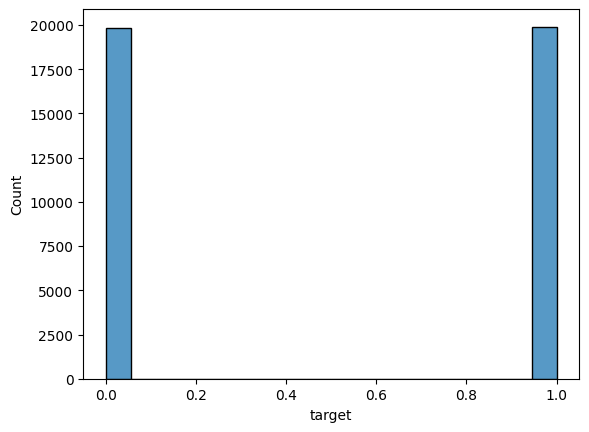

In [4]:
sns.histplot(data['target'])

**❓ Plot the title and target of the article at index 33**

In [5]:
data[['title', 'target']].iloc[33]

title     OBAMA’S BACKDOOR GUN CONFISCATION: 260,000 VET...
target                                                    1
Name: 33, dtype: object

### 1.2 Data cleaning

_C14 Convertir les données entrantes (images et texte par exemple) en données adaptées pour un réseau de neurones (100%)_

**❓ Create a new column `clean_text` that:**

1. Transform the column `full_text` from strings of words to a `list of words`
 - example : "Hilary Clinton is likely to become president" should become: **[Hilary, Clinton, is, likely, to, become, president]**


2. Then lowercase all words
 - example : [Hilary, Clinton, is, likely, to, become, president] should become: **[hilary, clinton, is, likely, to, become, president]**


3. Then remove empty words (ie = "")
 - example : ["", obama, speech] should become: **[obama, speech]**

**❓ Create `clean_text` to transform `full_text` into a feature with each articles being a list of words**

In [6]:
#first execute this cell to ensure that full_text only contains strings
data["full_text"] = data["full_text"].astype(str)

In [7]:
def lowercase(sentence):
    #$CHALLENGIFY_BEGIN
    result = [word.lower() for word in sentence if word != ""]
    return result

data['clean_text'] = data['full_text'].apply(lambda x: [word.lower() for word in x.split() if word != ""])
#data.clean_text = data.clean_text.apply(lowercase)
data
#$CHALLENGIFY_END

,title,content,full_text,target,length,clean_text
0,Alabama County Succeeds In Re-Instituting Sch...,The Republican-controlled southern states have...,Alabama County Succeeds In Re-Instituting Sch...,1,381,"[alabama, county, succeeds, in, re-instituting..."
1,Did You Spot The ‘Pants On Fire’ Moment In Tr...,The Trump campaign is busy attempting to clean...,Did You Spot The ‘Pants On Fire’ Moment In Tr...,1,358,"[did, you, spot, the, ‘pants, on, fire’, momen..."
2,Sarah Palin Faced Sexual Harassment At Fox Ne...,When high-profile women like Sarah Palin stay ...,Sarah Palin Faced Sexual Harassment At Fox Ne...,1,605,"[sarah, palin, faced, sexual, harassment, at, ..."
3,Marco Rubio NAILS IT: Trump As President Woul...,Florida Senator Marco Rubio has been going aft...,Marco Rubio NAILS IT: Trump As President Woul...,1,562,"[marco, rubio, nails, it:, trump, as, presiden..."
4,HOW GORSUCH Will Have Immediate Effect On Hist...,Neil M. Gorsuch joins the Supreme Court just i...,HOW GORSUCH Will Have Immediate Effect On Hist...,1,341,"[how, gorsuch, will, have, immediate, effect, ..."
...,...,...,...,...,...,...
39754,California Today: ‘Zoot Suit’ Memories - The N...,Good morning. (Want to get California Today b...,California Today: ‘Zoot Suit’ Memories - The N...,0,980,"[california, today:, ‘zoot, suit’, memories, -..."
39755,"Going Under the Knife, With Eyes and Ears Wide...","BENSALEM, Pa. — “Do you want to see your te...","Going Under the Knife, With Eyes and Ears Wide...",0,1854,"[going, under, the, knife,, with, eyes, and, e..."
39756,Confidence Even as Hillary Clinton’s Momentum ...,WASHINGTON — The announcement that the F. B...,Confidence Even as Hillary Clinton’s Momentum ...,0,1214,"[confidence, even, as, hillary, clinton’s, mom..."
39757,US Senate approves DeVos as education secretar...,With a tie-breaking vote by Vice President Mik...,US Senate approves DeVos as education secretar...,0,1931,"[us, senate, approves, devos, as, education, s..."


In [ ]:
# import string

# def clean_text (text) :
#     # # Remove uppercase
#     # text = text.lower()
#     # #Remove punctuations
#     # punctuations = string.punctuation
#     # for punctuation in punctuations:
#     #     text = text.replace(punctuation, '')
#     #slpit into a list of words :
#     text = text.slpit()
#     #text= text.remove("")

**❓ Transform `clean_text` in order to put all words lowercase and remove empty word**


#### 💾 Save your results

Run the cell below to save your results.

In [15]:
! mkdir tests

In [10]:
! pip install nbresult

In [16]:
import nbresult
from nbresult import ChallengeResult
result = ChallengeResult('rnn_data_cleaning',
                         first_article = data.clean_text[0],
                         article_shape = type(data.clean_text[0])
                        )
result.write()

Your goal is to train a recurrent neural network model to predict if an article is fake or not based solely on the title and content of the article.

- Create your X matrice feature, which **contains only your clean_text feature as ndarray**
- Create your target vector y as ndarray
- Create your holdout sets: 4 variables (X_train, y_train) and (X_test, y_test) keeping the first 70% as the train set
- X and y shapes should fit a RNN (model.fit(X,y)), and we will do it in the next coming cells!

😌 Don't worry, you will be given the solution in the next question in case you don't make it

**❓ Define X and y**

In [17]:
X = np.array(data.clean_text)
y= np.array(data.target)

**❓ Create X_train, X_test, y_train, y_test**

In [18]:
# Split into Train/Test
train_size = int(len(X) * 0.7)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

Execute this cell to remove unfrequent words to keep words that appear at least 20 times within the corpus

NameError: ignored

In [20]:
def get_number_of_occurences(sentences):
    occurences = {}
    for s in sentences:
        for w in s:
            if w not in occurences:
                occurences[w] = 0
            occurences[w] += 1
    return occurences

def keep_frequent_words(X, occurences, min_occurence):

    frequent_words = {k:v for k, v in occurences.items() if v >= min_occurence}
    output_sentences = [[word for word in sentence if word in frequent_words] for sentence in X]

    return output_sentences


# –– Data clearning
occurences = get_number_of_occurences(X_train)
X_clean_train = keep_frequent_words(X_train, occurences, min_occurence=20)
X_clean_test = keep_frequent_words(X_test, occurences, min_occurence=20)

**❓You will need to do some data preprocessing. First, start by tokenization. Don't forget to compute the size of your vocabulary under `vocab_size` variable 😉**

In [21]:
tk = Tokenizer()
tk.fit_on_texts(X_clean_train)
vocab_size = len(tk.word_index)
print(f'There are {vocab_size} different words in your corpus')


There are 25337 different words in your corpus


In [22]:

X_token_train = tk.texts_to_sequences(X_clean_train)
X_token_test = tk.texts_to_sequences(X_clean_test)


In [ ]:
vocab_size = 25337

**👉 Execute this cell to vizualise the histogram of article sizes**

(0.0, 4000.0)

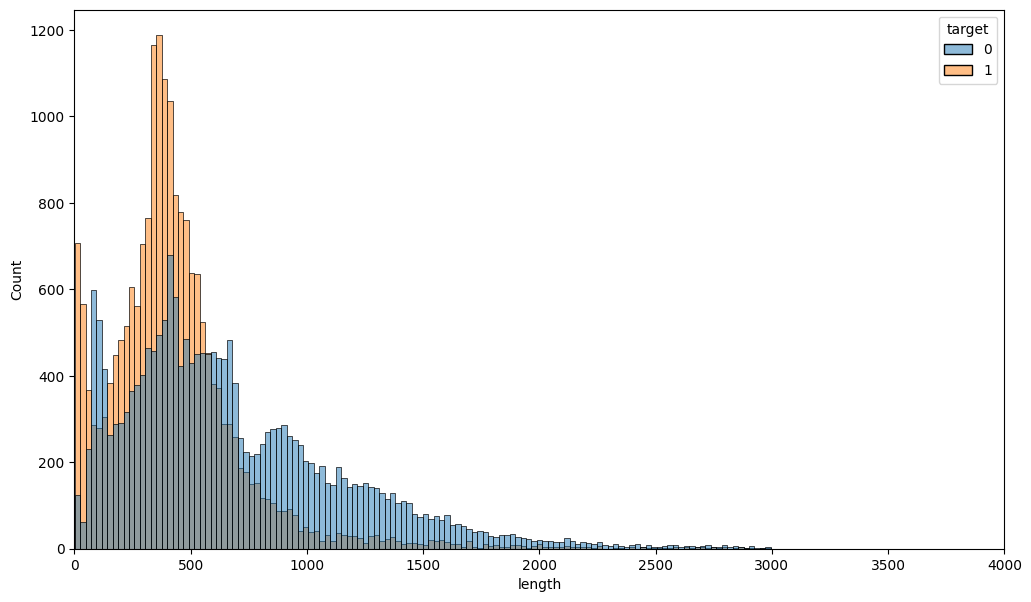

In [23]:
plt.figure(figsize=(12,7))
sns.histplot(data=data, x=data.length, hue=data.target)
plt.xlim(0,4000)

As you have noticed, most articles contains more than 500 words, but for computation time, we will here only keep the first 100 words.

**❓ Pad your data (use a value `maxlen` equal to 100)**
- Store it under `X_train_pad`and `X_test_pad`
- For computation reason, keep maximum **100 words**, this will still allow our model to have crucial information from articles, such as the title and the beginning of the article

In [24]:
from keras.utils import pad_sequences

X_train_pad = pad_sequences(X_token_train, padding="post", maxlen=100)
X_test_pad = pad_sequences(X_token_test, padding="post", maxlen=100)

#### 💾 Save your results

Run the cell below to save your results.

In [25]:
from nbresult import ChallengeResult
result = ChallengeResult('rnn_data_preprocessing',
                         X_train_pad_shape = X_train_pad.shape,
                         vocab_size = vocab_size)
result.write()

### 1.3 Training

_C15 Maîtriser les différentes architectures de réseau de neurones : convolutifs pour les images & récurrents pour les séries temporelles et les modèles de traitement automatique du langage (NLP) pour le texte (50%)_

_C17 Utiliser un réseau de neurones pour comprendre l'intention d'une phrase en langage naturel (100%)_

❓ **Before training a complex model, evaluate your baseline score**
- We will use the _accuracy_ as performance metric in this challenge
- What would be your baseline score?
- Store the result under `score_baseline`

 Only if you haven't managed to create your training sets above, you can start back from the solution by running the cell below

⚠️ This will download ~500Mo of .pickle files on your current working directory
Then it will load them into 4 ndarrays in memory, and it should delete initial .pickles from your disk


In [ ]:
import pickle

def download_solutions():
    file_names = ["articles_X_train_pad.pickle", "articles_X_test_pad.pickle", "articles_y_train.pickle", "articles_y_test.pickle"]
    pickles = dict()

    for file_name in file_names:
        file_path = f"data/articles/{file_name}"
        with open(file_path, 'rb') as handle:
            pickles[file_name] = pickle.load(handle)

    return pickles

# UNCOMMENT THIS LINE BELOW TO GET THE CORRECTION IF NEEDED
#X_train_pad, X_test_pad, y_train, y_test = download_solutions().values()

In [ ]:
#vocab_size = max([max(sequence) for sequence in X_train_pad]) + 1

In [30]:
score_baseline = np.average(y)
score_baseline

0.5006665157574386

❓ **Build and fit a neural network**

- Name it `model`
- Store output of `.fit()` in a variable `history`
- You **cannot** use transfer learning nor any other pre-trained models
- You must use a **Recurrent** architecture to _capture_ a notion of order in the sentences' words
- Do maximum 10 epochs, and set **batch_size to 64** to make training faster
- You don't need to cross-validate your model. Simply hold-out a validation set as you see fit
- Manage wisely your training time

💡 You will not be judged by the computing power of your computer, but you should obtain significantly better performance than the baseline in less than 5 minutes without GPUs

In [33]:

model = Sequential()
model.add(Embedding(input_dim=int(vocab_size)+1, output_dim=50, mask_zero=True))
model.add(LSTM(units=20, activation='tanh'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics='accuracy')

history_dict = model.fit(
    X_train_pad,
    y_train,
    batch_size=64,
    epochs=10,
    validation_split=0.2)

Epoch 1/10
348/348 [==============================] - 36s 86ms/step - loss: 0.2168 - accuracy: 0.9216 - val_loss: 0.4155 - val_accuracy: 0.9175
Epoch 2/10
348/348 [==============================] - 11s 32ms/step - loss: 0.0682 - accuracy: 0.9761 - val_loss: 0.9029 - val_accuracy: 0.6865
Epoch 3/10
348/348 [==============================] - 11s 32ms/step - loss: 0.0316 - accuracy: 0.9894 - val_loss: 0.3938 - val_accuracy: 0.8602
Epoch 4/10
348/348 [==============================] - 8s 22ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.7624 - val_accuracy: 0.8525
Epoch 5/10
348/348 [==============================] - 7s 19ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.5115 - val_accuracy: 0.8665
Epoch 6/10
348/348 [==============================] - 8s 24ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.5115 - val_accuracy: 0.9052
Epoch 7/10
348/348 [==============================] - 6s 18ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.5814 - val_accuracy: 0.8

❓ **Plot your training and validation Accuracy at each epoch using the cell below**

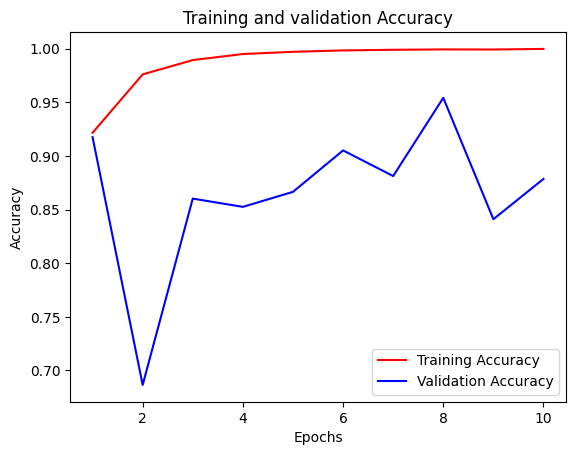

<Figure size 640x480 with 0 Axes>

In [36]:
# Plot below your train/val loss history
#$CHALLENGIFY_BEGIN

import matplotlib.pyplot as plt

acc = history_dict.history['accuracy']
val_acc = history_dict.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
#$CHALLENGIFY_END
# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
fig.savefig("tests/history_rnn.png")

❓ **Evaluate your performances on test set**
- Store your test score as `score_test`

In [41]:
score_test = model.evaluate(X_test_pad, y_test)[1]
score_test

373/373 [==============================] - 2s 5ms/step - loss: 1.1944 - accuracy: 0.8255


0.8255365490913391

#### 💾 Save your results

Run the cell below to save your results.

In [42]:
from nbresult import ChallengeResult
import tensorflow as tf

result = ChallengeResult(
    "rnn",
    input_shape = list(model.input.shape),
    output_shape = list(model.output.shape),
    X_train_pad_random = X_train_pad[33],
    layer_names = [layer.name for layer in model.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in model.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()

##  😀 CNN challenge - Smile Detector

**ℹ️ This challenge assesses the following skills of the third block of the certification _Reconnaissance de formes par réseaux de neurones artificiels_:**
- C15 Maîtriser les différentes architectures de réseau de neurones : convolutifs pour les images & récurrents pour les séries temporelles et les modèles de traitement automatique du langage (NLP) pour le texte (50%)
- C16 Utiliser un réseau de neurones convolutifs pour étiqueter des images (100%)

### Objectives
-  Visualize images (10 minutes)
-  Fit a custom CNN for a regression task (30 minutes)
-  Fine-tune an analyse model performance (20 minutes)

### 2.1 Data Preparation (given)

Our dataset contains 7000 human faces along with the binary class 1 for a smiling person or 0 for non smiling one

In [43]:
# We load the dataset for you
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification/fake_news_real_smiles/cleaned_smile.csv")
data.head()

,pixels,smile
0,141 140 142 146 148 147 149 152 158 160 162 16...,1
1,78 75 71 64 66 78 86 92 94 94 95 98 105 115 12...,1
2,143 145 146 146 146 146 148 150 152 158 160 15...,1
3,55 54 54 54 54 54 53 53 55 53 78 126 152 170 1...,1
4,91 94 99 103 105 107 117 130 140 151 163 168 1...,1


Each row represent the image of a human face in black and white
- `smile` is the target : 0 for a non smiling person, 1 for a smiling person
- `pixels` contains the 4096 (= 64 * 64) flatten values of each pixel in the image, in a black scale from 0 to 255, stored as string

**❓ Plot the histogram of smile in your dataset.**

<Axes: xlabel='smile', ylabel='Count'>

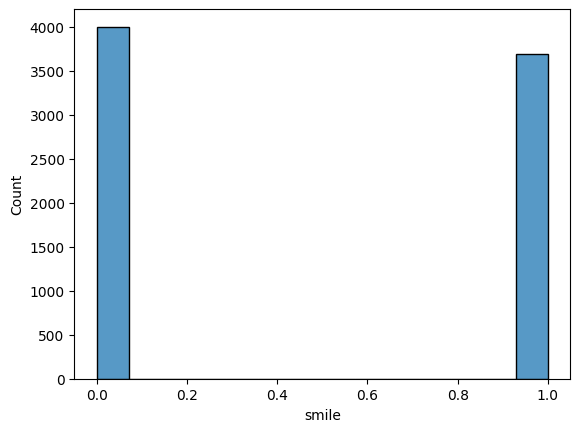

In [44]:
sns.histplot(data['smile'])

**❓ Visually display one image of your choice.**

In [45]:
def img_show(index):
    # Select an image index
    image_index = index

    # Convert the string of pixel values to an array of integers
    pixels = np.array(data.loc[image_index, 'pixels'].split(), dtype=int)

    # Reshape the array to the original image shape
    image = pixels.reshape(64, 64)

    # Display the image
    plt.imshow(image, cmap='viridis')
    plt.axis('off')
    plt.show()

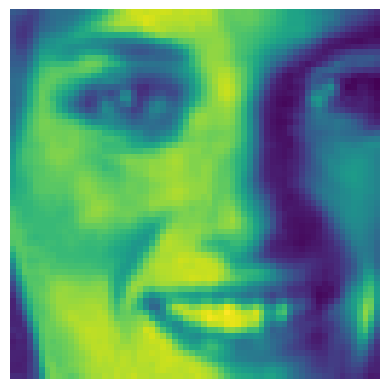

In [46]:
img_show(1)

**❓ What is the physical characteristic of the image at _index_ `40`?**

- Store in the 3 boolean variables `smile`/`glasses`/`hat` the values `True` if the person smiles/wears glasses/has a hat, `False` else.

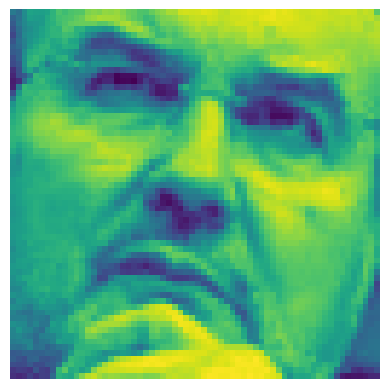

In [47]:
img_show(40)

In [48]:
smile = False

In [49]:
glasses = True
hat = False

#### 💾 Save your results

Run the cell below to save your results.

In [50]:
from nbresult import ChallengeResult
result = ChallengeResult('cnn_images_visualization',
                         smile=smile,
                         glasses=glasses,
                         hat=hat)
result.write()

### 2.2 Data Preprocessing (given)

Then we performed the following preprocessing for you:
- We converted each image into a list of integers, each integer being one pixel of the image

- We normalized the pixel size by dividing by 255

- split the data into train and test set

Please, execute the following cells:

In [51]:
# We create features
y = data.smile
X = data.pixels

# We analyse class balance which gives us a baseline to beat
print(pd.value_counts(y))

0    4000
1    3690
Name: smile, dtype: int64


In [52]:
#from strings to list of integers
X = data["pixels"].apply(lambda x: np.array(x.split(), dtype="int32"))
X = np.vstack(X)

#unflattened image
X = X.reshape(-1, 64, 64, 1)

# Normalize data
X = X / 255.

In [53]:
#train test split (70/30 ratio)
idx_split = round(len(X)*0.7)

X_train = X[0:idx_split]
y_train = y[0:idx_split]
X_test = X[idx_split:]
y_test = y[idx_split:]

assert len(X_train) + len(X_test) == len(X)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5383, 64, 64, 1) (5383,) (2307, 64, 64, 1) (2307,)


### 2.3 Model Training

❓ **Before training a complex model, let's think about the performance metrics we will use**
- We want to avoid false alarms as much as possible, so that we want our model to avoid predicting that someone smiles if he is not
- which [keras metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) will we use ?
- Store the result under `scoring_metric`

In [55]:
# from tensorflow.keras.metrics import Precision
# scoring_metric = Precision()
# scoring_metric
scroring_metric = 'precision'

❓ **Build and fit a convolutional neural network**

- Name it `model`
- Store output of `.fit()` in a variable `history`
- Do not use transfer learning
- Make sure your model does not overfit with appropriate control techniques

💡 Manage wisely your training time. You should obtain significantly better performance than the baseline in less than 5 minutes with average processor and no graphic cards.

In [63]:
from tensorflow.keras.metrics import Precision

#instantiate and create model :
model = Sequential()
#add CON2D layes with maxpooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#Flatten for outputshape
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
#Binary output :
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='Precision'
)

#es = EarlyStopping(patience=4)
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    #callbacks=[es]
)


Epoch 1/100
68/68 [==============================] - 3s 13ms/step - loss: 0.6651 - precision: 0.7291 - val_loss: 0.5585 - val_precision: 0.6516
Epoch 2/100
68/68 [==============================] - 1s 9ms/step - loss: 0.3960 - precision: 0.8185 - val_loss: 0.3538 - val_precision: 0.9284
Epoch 3/100
68/68 [==============================] - 1s 10ms/step - loss: 0.3302 - precision: 0.8594 - val_loss: 0.3242 - val_precision: 0.8249
Epoch 4/100
68/68 [==============================] - 1s 9ms/step - loss: 0.3156 - precision: 0.8642 - val_loss: 0.3332 - val_precision: 0.9345
Epoch 5/100
68/68 [==============================] - 1s 9ms/step - loss: 0.2886 - precision: 0.8786 - val_loss: 0.2919 - val_precision: 0.9032
Epoch 6/100
68/68 [==============================] - 1s 9ms/step - loss: 0.2809 - precision: 0.8826 - val_loss: 0.2894 - val_precision: 0.8931
Epoch 7/100
68/68 [==============================] - 1s 11ms/step - loss: 0.2672 - precision: 0.8927 - val_loss: 0.2820 - val_precision: 0.8

In [ ]:
# YOUR CODE HERE

❓ **Plot your training and validation metric at each epoch using the cell below**

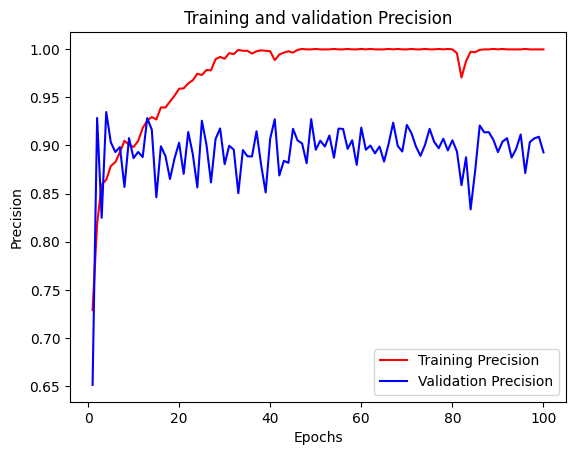

<Figure size 640x480 with 0 Axes>

In [65]:
# Plot below your train/val loss history
#$CHALLENGIFY_BEGIN

pre = history.history['precision']
val_pre = history.history['val_precision']

epochs = range(1, len(pre) + 1)

plt.plot(epochs, pre, 'r', label='Training Precision')
plt.plot(epochs, val_pre, 'b', label='Validation Precision')

plt.title('Training and validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.show()
#$CHALLENGIFY_END

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
fig.savefig("tests/history_cnn.png")

❓ **Evaluate your performances on test set**
- Store your test score as `score_test`

In [66]:
score_test = model.evaluate(X_test, y_test)[1]
score_test

73/73 [==============================] - 0s 5ms/step - loss: 0.7258 - precision: 0.8628


0.8627968430519104

#### 💾 Save your results

Run the cell below to save your results.

In [67]:
from nbresult import ChallengeResult
import tensorflow as tf

result = ChallengeResult(
    "cnn",
    input_shape = list(model.input.shape),
    output_shape = list(model.output.shape),
    layer_names = [layer.name for layer in model.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in model.trainable_variables]),
    scoring_metric = scoring_metric,
    score_test = score_test,
)
result.write()